In [1]:
import os
import urllib.request, json 
import pandas as pd
from IPython.display import HTML
from IPython import display
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
import numpy as np
from typing import Iterable
from pyciemss.utils.interface_utils import (
    assign_interventions_to_timepoints,
    interventions_and_sampled_params_to_interval,
    convert_to_output_format
)
from pyciemss.utils import get_tspan
import matplotlib.pyplot as plt
import torch
from torch import tensor

Plotting utils

In [18]:
COLORS=['red','green','blue','black','gold','purple','orangered']

def aggregate_results(samples_df, num_samples=1):
    QoIs = ["D_sol", "E_sol", "I_sol", "R_sol", "S_sol"]
    all_QoIs = {key: None for key in QoIs}
    for QoI in QoIs:
        # Aggregate results
        # TODO: After they introduce normalized models, remove normalization here.
        # /total_pop * 100
        # total_pop = 0
        # for val in QoIs:
        #     total_pop += samples_df[samples_df["sample_id"] == 0][val].to_numpy()[0]
        all_QoIs[QoI] = [samples_df[samples_df["sample_id"] == i][QoI].to_numpy() for i in range(num_samples)]
    return all_QoIs

def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None, ax=None):
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=(10,4))
    N = S[0] + E[0] + I[0] + R[0] + D[0]
    ax.plot(t, (S/N)*100, 'b--', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, (E/N)*100, 'y.', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, (I/N)*100, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, (R/N)*100, 'g-.', alpha=0.7, linewidth=2, label='Recovered')

    if D is not None:
        ax.plot(t, D/N, 'k', alpha=0.7, linewidth=2, label='Dead')
        ax.plot(t, ((S+E+I+R+D)/N)*100, 'c:', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, ((S+E+I+R)/N)*100, 'c:', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Percentage of Population (%)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    # plt.show()

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))
    
    if R0 is not None:
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    if Alpha is not None:
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

        ax2.set_xlabel('Time (days)')
        ax2.title.set_text('fatality rate over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax2.yaxis.set_tick_params(length=0)
        ax2.xaxis.set_tick_params(length=0)
        ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax2.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    # plt.show()

MIRA Model Utils

In [31]:
# Add '?raw=true' at the end of the link to the file to get the rawgithubusercontent link.
def update_AMR(SEIRD_model_url, SEIRD_model_path):
    with urllib.request.urlopen(SEIRD_model_url) as url:
        json_object = json.load(url)
        with open(SEIRD_model_path, "w") as outfile:
            json.dump(json_object, outfile)

# SCENARIO 1: Forecasting with non-pharmaceutical interventions (NPIs) such as, masking and social distancing. 

**"You want to implement a masking intervention in a simple compartmental model and simulate epidemic trajectories under different compliance scenarios. You found an existing model that incorporates masking as a time-dependent modification to the $\beta$ parameter, and you want to ensure that the model is working as expected by reproducing plots in the publication"**

### PART 1
**(A)** TA1/TA2 provide the AMR for a COVID-19 model with compartments SEIRD (Susceptible, Exposed, Infected, Recovered, Death) and, importantly, a time-dependent transmission rate $\beta$. A mask order may be implemented $t_0$ days after the first case is detected (at time $t = 0$), and $\beta$ varies in time according to the effectiveness of the NPI under various levels of compliance.\
Transmission rate $\beta(t)$ is defined as, \begin{align} \beta(t) &= \kappa m(t) \\
m(t) &= \beta_c + \frac{\beta_s - \beta_c}{1 + e^{-k (t_0 - t)}},
\end{align}
where $\kappa$ is an arbitrary constant, and $m(t)$ represents adoption of a mask order $t_0$ days after the first case is detected, assuming 100% compliance. \
Model Source: https://doi.org/10.3390/ijerph18179027 \
AMR location: https://github.com/indralab/mira/blob/hackathon/notebooks/hackathon_2023.07/scenario1_a.json 

Model Schematic:

<div>
<img src="https://i.imgur.com/GXshSZH.png" width="600" align="left"/>
</div>

In [22]:
# 1b
SEIRD_model_path = "scenario1_a.json"
SEIRD_model_url = "https://raw.githubusercontent.com/indralab/mira/hackathon/notebooks/hackathon_2023.07/scenario1_a.json"
# NOTE: This is only if you wish to update the AMR.
update_AMR(SEIRD_model_url, SEIRD_model_path)

In [5]:
def change_model_parameters(filename, new_params):
    # new params = [(param, value), (param, value)]
    with open(filename, 'r') as f:
        model = json.load(f)
        # Change initial parameters
        for (param, value) in new_params:
            for idx in model["semantics"]["ode"]["parameters"]:
                if idx["id"] == param:
                    idx["value"] = value
    return model

### TA3 TASK 1:
**(B)** Perform model simulation with various delays ($t_0$ values) in mask order implementation, and reproduce Fig. 3, including peak prevalence estimates. 

Figure 3 from the paper
<div>
<img src="https://i.imgur.com/u41OiB6.png" width="500" align="left"/>
</div>

Simulation Parameters

In [6]:
num_samples = 1
start_time = 0
end_time = 365
num_timepoints = (end_time-start_time)*10 + 1
timepoints = get_tspan(start_time, end_time, num_timepoints)

#### Figure 3 Recreation

Case A - 0 Days Delay of Mask Mandate

In [37]:
SEIRD_model_path = "scenario1_c.json"

model = change_model_parameters(SEIRD_model_path, [("t_0", 0)])
implement_0day_samples = load_and_sample_petri_model(
        model, num_samples, timepoints=timepoints)
QoIs_0day = aggregate_results(implement_0day_samples, num_samples)

KeyboardInterrupt: 

Case B - 50 Days Delay of Mask Mandate

In [24]:
model = change_model_parameters(SEIRD_model_path, [("t_0", 50)])
implement_50day_samples = load_and_sample_petri_model(
        model, num_samples, timepoints=timepoints)
QoIs_50day = aggregate_results(implement_50day_samples, num_samples)

Case C - 100 Days Delay of Mask Mandate

In [25]:
model = change_model_parameters(SEIRD_model_path, [("t_0", 100)])
implement_100day_samples = load_and_sample_petri_model(
        model, num_samples, timepoints=timepoints)
QoIs_100day = aggregate_results(implement_100day_samples, num_samples)

Case D - Control (no intervention)

In [26]:
model = change_model_parameters(SEIRD_model_path, [("t_0", 365)])
control_samples = load_and_sample_petri_model(
        model, num_samples, timepoints=timepoints)
QoIs_control = aggregate_results(control_samples, num_samples)

Plot results and recreate Figure 3

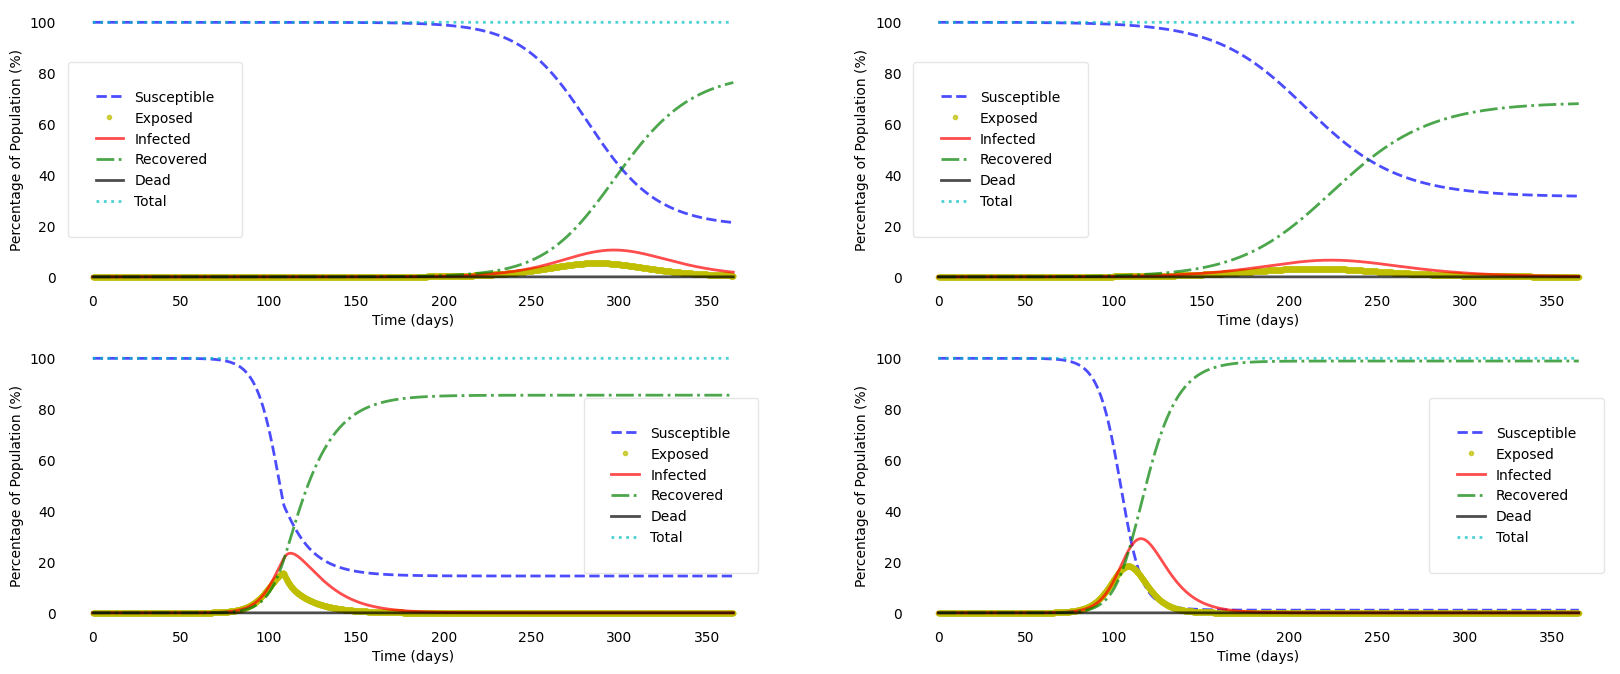

In [27]:
QoIs_0day = aggregate_results(implement_0day_samples, num_samples)
QoIs_50day = aggregate_results(implement_50day_samples, num_samples)
QoIs_100day = aggregate_results(implement_100day_samples, num_samples)
QoIs_control = aggregate_results(control_samples, num_samples)

f, ax = plt.subplots(2,2,figsize=(20,8))
plotseird(timepoints, QoIs_0day["S_sol"][0], QoIs_0day["E_sol"][0], QoIs_0day["I_sol"][0], QoIs_0day["R_sol"][0], QoIs_0day["D_sol"][0], ax=ax[0][0])
plotseird(timepoints, QoIs_50day["S_sol"][0], QoIs_50day["E_sol"][0], QoIs_50day["I_sol"][0], QoIs_50day["R_sol"][0], QoIs_50day["D_sol"][0], ax=ax[0][1])
plotseird(timepoints, QoIs_100day["S_sol"][0], QoIs_100day["E_sol"][0], QoIs_100day["I_sol"][0], QoIs_100day["R_sol"][0], QoIs_100day["D_sol"][0], ax=ax[1][0])
plotseird(timepoints, QoIs_control["S_sol"][0], QoIs_control["E_sol"][0], QoIs_control["I_sol"][0], QoIs_control["R_sol"][0], QoIs_control["D_sol"][0], ax=ax[1][1])
plt.savefig("scenario1b_recreatefig3.png")
plt.show()
# TODO: Change to 1b if using 1b model


In [28]:
def get_max_and_time(data, col_name, num_samples, timepoints):
    max_vals = [data[col_name][data["sample_id"] == i].max() for i in range(num_samples)]
    max_times_row = [data[col_name][data["sample_id"] == i].idxmax() for i in range(num_samples)]
    max_time_ids = [data["timepoint_id"][i] for i in max_times_row]
    max_times = [timepoints[i] for i in max_time_ids]
    return pd.DataFrame({"sample_id": list(range(num_samples)), f"max_{col_name}": max_vals, "max_time": max_times})
max_infections_0day  = get_max_and_time(implement_0day_samples, "I_sol", num_samples, timepoints)
max_infections_50day  = get_max_and_time(implement_50day_samples, "I_sol", num_samples, timepoints)
max_infections_100day  = get_max_and_time(implement_100day_samples, "I_sol", num_samples, timepoints)
max_infections_control  = get_max_and_time(control_samples, "I_sol", num_samples, timepoints)
print("Mask delay enforcement: Max infections and time of max infection")
print("0 Days:", max_infections_0day)
print("50 Days:", max_infections_50day)
print("100 Days:", max_infections_100day)
print("Control:", max_infections_control)

# ax[0,0].plot(timepoints[max_infection_time_0day], max_infections_0day, 'ro')
# ax[0,0].text(timepoints[max_infection_time_0day], max_infections_0day, f"Max infection")
# ax[0,1].plot(timepoints[max_infection_time_50day], max_infections_50day, 'ro')
# ax[0,1].text(timepoints[max_infection_time_50day], max_infections_50day, "Max infection")
# ax[1,0].plot(timepoints[max_infection_time_100day], max_infections_100day, 'ro')
# ax[1,0].text(timepoints[max_infection_time_100day], max_infections_100day, "Max infection")
# ax[1,1].plot(timepoints[max_infection_time_control], max_infections_control, 'ro')
# ax[1,1].text(timepoints[max_infection_time_control], max_infections_control, "Max infection")

Mask delay enforcement: Max infections and time of max infection
0 Days:    sample_id  max_I_sol      max_time
0          0   590434.0  tensor(297.)
50 Days:    sample_id   max_I_sol          max_time
0          0  367558.375  tensor(223.9000)
100 Days:    sample_id   max_I_sol          max_time
0          0  1311549.75  tensor(112.7000)
Control:    sample_id    max_I_sol          max_time
0          0  1632026.875  tensor(115.5000)


**(C)** TA2 updates the AMR to redefine $\beta(t)$ as, \begin{align} \beta(t) &= \kappa m(t) \\
m(t) &= \beta_{nc} + \frac{\beta_s - \beta_c}{1 + e^{-k_1(t_0 - t)}} + \frac{\beta_c - \beta_{nc}}{1 + e^{-k_2(t_1 - t)}}, \end{align}
to model gradual non-compliance with a mask order. \
AMR location: https://github.com/indralab/mira/blob/hackathon/notebooks/hackathon_2023.07/scenario1_c.json 

**TA3 TASK 2:** Perform model simulation over a range of delays in mask enforcement, and plot the peak prevalence to reproduce Fig. 5.

Delay List = [0, 10, 25, 50, 65, 75, 80, 90, 95, 100, 125, 150]
<div>
<img src="https://i.imgur.com/dDQX87i.png" width="500" align="left"/>
</div>

Load new model, 8 and 10, with k1 = 5, and k2 = 1.

In [33]:
SEIRD_model_path = "scenario1_c.json"
SEIRD_model_url = "https://raw.githubusercontent.com/indralab/mira/hackathon/notebooks/hackathon_2023.07/scenario1_c.json"
update_AMR(SEIRD_model_url, SEIRD_model_path)

In [34]:
t0_values = [0, 10, 25, 50, 65, 75, 80, 90, 95, 100, 125, 150]
mask_delay_results = {}
for t0 in t0_values:
    model = change_model_parameters(SEIRD_model_path, [("t_0", t0)])
    samples = load_and_sample_petri_model(
        model, num_samples, timepoints=timepoints)
    total_pop = samples["S_sol"][0] + samples["E_sol"][0] + samples["I_sol"][0] + samples["R_sol"][0] + samples["D_sol"][0]
    mask_delay_results[t0] = get_max_and_time(samples, "I_sol", num_samples, timepoints)["max_I_sol"]/total_pop * 100

    # mask_delay_results[t0] = {"data": data, "max_infection": max(data["I_sol"][0])}

/Users/vigneshsella/Documents/GitHub/pyciemss/src/pyciemss/PetriNetODE/base.py:334: UserWarning: Parameter t_0 has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)
/Users/vigneshsella/Documents/GitHub/pyciemss/src/pyciemss/PetriNetODE/base.py:330: UserWarning: Parameter (('S', ('identity', 'ido:0000514')), ('E', ('identity', 'apollosv:0000154')), ('I', ('identity', 'ido:0000511')), 'ControlledConversion', 'rate') has value None and will be set to Uniform(0, 1)
  warnings.warn(warnings_string)
/Users/vigneshsella/Documents/GitHub/pyciemss/src/pyciemss/PetriNetODE/base.py:330: UserWarning: Parameter (('I', ('identity', 'ido:0000511')), ('R', ('identity', 'ido:0000592')), 'NaturalConversion', 'rate') has value None and will be set to Uniform(0, 1)
  warnings.warn(warnings_string)
/Users/vigneshsella/Documents/GitHub/pyciemss/src/pyciemss/PetriNetODE/base.py:330: UserWarning: Parameter (('I', ('identity', 'ido:0000511')), ('D', ('identity', 'ncit:C28554'

KeyboardInterrupt: 

Plot max infection values

Text(0, 0.5, 'Max infection (% of population)')

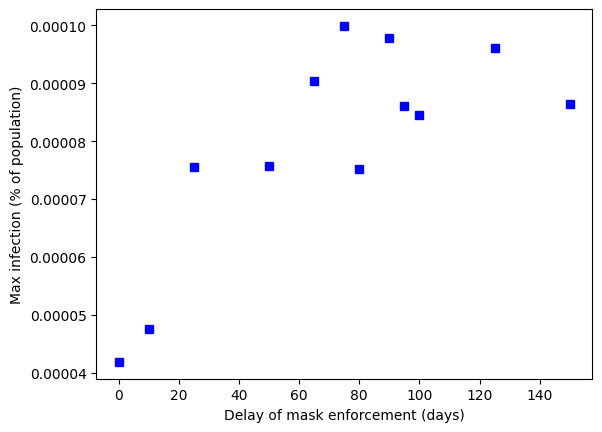

In [ ]:
# All max_infection values
max_infection_values = [mask_delay_results[t0] for t0 in mask_delay_results.keys()]
# Plot max_infection vs t0 with blue square markers
plt.plot(t0_values, max_infection_values, 'bs')
plt.xlabel("Delay of mask enforcement (days)")
plt.ylabel(r"Max infection (% of population)")

**(D)** TA2 updates AMR of SEIRD model to include possibility for reinfection, producing the SEIRS model.
AMR location: https://github.com/indralab/mira/blob/hackathon/notebooks/hackathon_2023.07/scenario1_d.json \
Model Schematic:
<div>
<img src="https://i.imgur.com/KMgRtbO.png" width="300" align="left"/>
</div>

**TA3 TASK 3:** Perform model simulation and again reproduce Fig. 5 (as in TASK 2). Compare with previous results (as in 1C), "what impact does immunity loss and potential for reinfection have?"

**(E) TA3 TASK 4:** Repeat the previous SEIRS model simulation (as in TASK 3), but add *uncertainty* by assessing a range of non-compliance levels (as defined by $\beta_{nc}$ and $k_2$) and reinfection rates (as controlled through $\epsilon$). Plot the state variables over time along with the uncertainty ranges.

In [ ]:
# TODO: Only possible once deterministic parameters are permissible.

### PART 2
**(D) TA3 Recommended TASK 5:** Find a real-world example of a mask order being implemented. Calibrate the model from Part 1A using data from the COVID-19 ForecastHub for a period before the mask intervention is implemented, and forecast through the intervention period. Demonstrate how the forecast varies based on compliance rates.